# The Battle of Neighborhood - Coursera Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to investigate what venues have higher frequency in **New York** and **Toronto**. And we also will compare the distribution of venues in two cities to find out what venues are more common in one than the other.

Since there are lots of venues we will try to detect **the top 10 popular venues in each city**. We are also particularly interested in **venues with low frequency**.

This project is aiming to help new business to choose their venue types and avoid venues with high density in certain area. Eventually, it can create higher profit for the new business starter.

## Data <a name="data"></a>

We will use three data sources to complete this project. For the data of New York Neighborhood, we obtain a JSON file from the following link:

https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

Next, we get the latitude and longitude data by geopy library.

For the data of Toronto Neighborhood, we get the postal code and neighborhood information from Wikipedia and merge latitude and longitude data into the dataset. The file contains latitude and longitude data can be downloaded via the following link"

http://cocl.us/Geospatial_data

Finally, we use Foursquare API to collect the information about venues corresponding with neighborhoods to derive a integral dataset containing Neighborhood, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, and Venue Category for the further analysis.

### Data 1.1

#### Download and explore neighborhood data for New York

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

/bin/sh: wget: command not found
Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
newyork_neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_neighborhoods = pd.DataFrame(columns=column_names)

for data in newyork_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_neighborhoods = newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_neighborhoods['Borough'].unique()),
        newyork_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_neighborhoods['Latitude'], newyork_neighborhoods['Longitude'], newyork_neighborhoods['Borough'], newyork_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Using Foursquare API to explore Venue Data For New York

In [10]:
CLIENT_ID = 'MJ1HLI3W5IRID0V5VDF10ZXGMJHY2GW1RRWZQDAUFTXP3EXN' # your Foursquare ID
CLIENT_SECRET = 'UHTGCPLGRHFLPHNFRRAGUN0VUWW4QMC1THENSC3VAF4KUN0B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MJ1HLI3W5IRID0V5VDF10ZXGMJHY2GW1RRWZQDAUFTXP3EXN
CLIENT_SECRET:UHTGCPLGRHFLPHNFRRAGUN0VUWW4QMC1THENSC3VAF4KUN0B


#### Explore Neighborhoods in New York

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
newyork_venues = getNearbyVenues(names=newyork_neighborhoods['Neighborhood'],
                                   latitudes=newyork_neighborhoods['Latitude'],
                                   longitudes=newyork_neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [13]:
print(newyork_venues.shape)
newyork_venues.head()

(10112, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [14]:
newyork_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                      30
Annadale                      11
Arden Heights                  5
Arlington                      6
Arrochar                      22
Arverne                       20
Astoria                       99
Astoria Heights               13
Auburndale                    21
Bath Beach                    46
Battery Park City             66
Bay Ridge                     81
Bay Terrace                   47
Baychester                    20
Bayside                       72
Bayswater                      1
Bedford Park                  36
Bedford Stuyvesant            28
Beechhurst                    16
Bellaire                      13
Belle Harbor                  17
Bellerose                     19
Belmont                       97
Bensonhurst                   36
Bergen Beach                   7
Blissville                    19
Bloomfield                     4
Boerum Hill                   90
Borough Park                  22
Breezy Point                  

In [15]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 428 uniques categories.


### Data 1.2

#### Download and explore neighborhood data for Toronto

In [35]:
# !pip3 install lxml
toronto_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
toronto_neighborhoods = toronto_neighborhoodss[0]

In [36]:
toronto_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [38]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Borough != 'Not assigned']

In [39]:
toronto_neighborhoods = (toronto_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

In [40]:
toronto_neighborhoods.loc[toronto_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Neighborhood'] = \
    toronto_neighborhoods.loc[toronto_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Borough']

#### Get the latitude and the longitude coordinates of each neighborhood

In [41]:
df2 = pd.read_csv('http://cocl.us/Geospatial_data')
df2.columns = ['PostalCode', 'Latitude', 'Longitude']
df2.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [42]:
toronto_neighborhoods = pd.merge(toronto_neighborhoods, df2, on = ['PostalCode'], how = 'inner')
toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [43]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


In [44]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(
        toronto_neighborhoods['Latitude'], 
        toronto_neighborhoods['Longitude'], 
        toronto_neighborhoods['Borough'], 
        toronto_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
map_toronto

In [48]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods['Neighborhood'],
                             latitudes=toronto_neighborhoods['Latitude'],
                             longitudes=toronto_neighborhoods['Longitude']
                            )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [91]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [49]:
toronto_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                   5
Alderwood, Long Branch                                                                                                                      7
Bathurst Manor, Wilson Heights, Downsview North                                                                                            21
Bayview Village                                                                                                                             4
Bedford Park, Lawrence Manor East                                                                                                          22
Berczy Park                                                                                                                                55
Birch Cliff, Cliffside West                                                                                                            

In [51]:
toronto_excluded_neighborhoods = set(toronto_neighborhoods['Neighborhood']).difference(set(toronto_venues['Neighborhood']))
toronto_excluded_neighborhoods

{'Islington Avenue, Humber Valley Village',
 'Upper Rouge',
 'Willowdale, Newtonbrook'}

In [52]:
# number of unique categories of venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


## Methodology <a name="methodology"></a>

In this project we will work on detecting top 10 popular venues in New York and Toronto to help new business finding their direction.

In first step we have collected the required data: Neighborhood, Venue, Latitude and Longtitude. We have also plot the location of each neighborhood in the map.

Second step in our analysis will be finding the top 10 popular venues in each neighborhood and located them in the map.

In third and final step we will focus on cluster the locations of the venues in two cities to identify similar venue types in different areas.

## Analysis <a name="analysis"></a>

#### Analyze The Top 10 Popular Venues In New York

In [16]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood_'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical S

In [17]:
newyork_onehot.shape

(10112, 429)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [18]:
newyork_grouped = newyork_onehot.groupby('Neighborhood_').mean().reset_index()
newyork_grouped.head()

,Neighborhood_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical S

#### The most common categories for each neighborhood

In [19]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]

In [20]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_categories_sorted['Neighborhood_'] = newyork_grouped['Neighborhood_']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        newyork_grouped.iloc[ind, :], num_top_venues)

newyork_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton,Pizza Place,Chinese Restaurant,Deli / Bodega,Spa,Supermarket,Fried Chicken Joint,Donut Shop,Bakery,Pharmacy,Electronics Store
1,Annadale,American Restaurant,Pizza Place,Diner,Deli / Bodega,Dance Studio,Food,Restaurant,Park,Train Station,Field
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
3,Arlington,Deli / Bodega,Coffee Shop,Bus Stop,Home Service,Boat or Ferry,Grocery Store,Flower Shop,Farm,Farmers Market,Fast Food Restaurant
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Hotel,Supermarket,Sandwich Place,Liquor Store,Outdoors & Recreation,Pharmacy,Pizza Place


#### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [22]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [23]:
# add clustering labels
newyork_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = newyork_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(newyork_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

newyork_merged.head() # check the last columns!

,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Bronx,Wakefield,40.894705,-73.847201,0,Pharmacy,Donut Shop,Pizza Place,Ice Cream Shop,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Deli / Bodega,Farm
1,Bronx,Co-op City,40.874294,-73.829939,0,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Bronx,Eastchester,40.887556,-73.827806,0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Cosmetics Shop,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
3,Bronx,Fieldston,40.895437,-73.905643,0,Medical Supply Store,River,Plaza,Fish Market,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
4,Bronx,Riverdale,40.890834,-73.912585,0,Park,Food Truck,Gym,Home Service,Moving Target,Plaza,Bank,Bus Station,Playground,Farmers Market


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood_'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Exam Clusters

In [25]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Wakefield,Pharmacy,Donut Shop,Pizza Place,Ice Cream Shop,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Deli / Bodega,Farm
1,Co-op City,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Eastchester,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Cosmetics Shop,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
3,Fieldston,Medical Supply Store,River,Plaza,Fish Market,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
4,Riverdale,Park,Food Truck,Gym,Home Service,Moving Target,Plaza,Bank,Bus Station,Playground,Farmers Market


In [26]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
192,Somerville,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
203,Todt Hill,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [27]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
179,Neponsit,Beach,Yoga Studio,Food,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


In [28]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
207,Port Ivory,Bar,Food,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


In [29]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]].head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
303,Bayswater,Playground,Yoga Studio,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


##### Analyze The Top 10 Popular Venues In Toronto

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
toronto_onehot['Neighborhood_'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [54]:
toronto_grouped = toronto_onehot.groupby('Neighborhood_').mean().reset_index()
toronto_grouped.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0

In [55]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))
# create a new dataframe
toronto_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_categories_sorted['Neighborhood_'] = toronto_grouped['Neighborhood_']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Greek Restaurant,Discount Store,Department Store,Dessert Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Ice Cream Shop,Bridal Shop,Shopping Mall,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher


#### Run k-means to cluster the neighborhood into 5 clusters.

In [58]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       3, 0, 0, 0, 0, 0, 3, 1], dtype=int32)

In [59]:

# add clustering labels
toronto_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
toronto_merged = toronto_merged[~toronto_merged['Neighborhood_'].isin(toronto_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')
# toronto_merged = toronto_merged.astype({'Cluster Labels': int})
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood_,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Health & Beauty Service
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2,Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Breakfast Spot,Restaurant,Electronics Store,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Bank,Yoga Studio,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Mexican Restaurant,Korean Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Gas Station,Fried Chicken Joint,Bakery,Bank,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Electronics Store,Eastern European Restaurant


In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood_'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Scarborough,0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Health & Beauty Service
2,Scarborough,0,Breakfast Spot,Restaurant,Electronics Store,Medical Center,Rental Car Location,Intersection,Mexican Restaurant,Bank,Yoga Studio,Doner Restaurant
3,Scarborough,0,Coffee Shop,Mexican Restaurant,Korean Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
4,Scarborough,0,Gas Station,Fried Chicken Joint,Bakery,Bank,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Electronics Store,Eastern European Restaurant
5,Scarborough,0,Playground,Smoke Shop,Jewelry Store,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
20,North York,1,Martial Arts School,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
1,Scarborough,2,Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
91,Etobicoke,2,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
97,North York,2,Baseball Field,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field


In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
14,Scarborough,3,Playground,Park,Bakery,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
23,North York,3,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
25,North York,3,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
40,East York,3,Intersection,Park,Convenience Store,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
44,Central Toronto,3,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
94,Etobicoke,4,Print Shop,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Dim Sum Restaurant


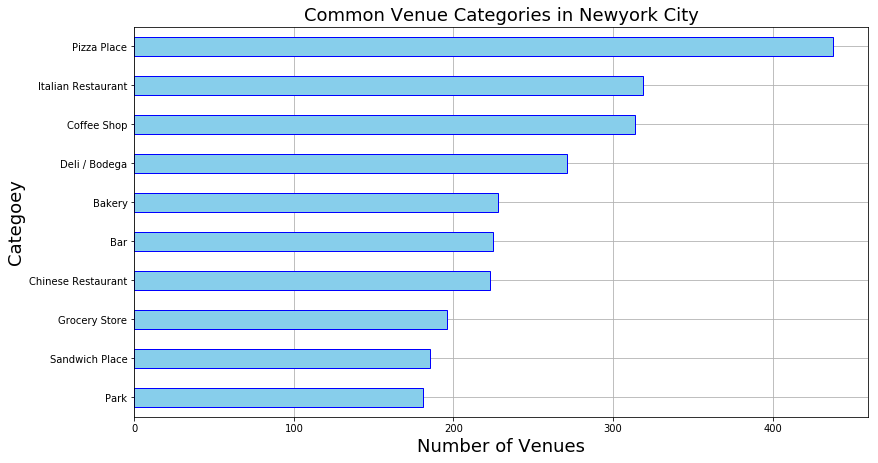

In [67]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12,6))
newyork_top_vc = newyork_venues['Venue Category'].value_counts(normalize=False)
ax = newyork_top_vc.head(10).plot(kind='barh', grid=True, color = "skyblue", edgecolor='blue');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Newyork City', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('newyork_most_common_venue.png', dpi=300)

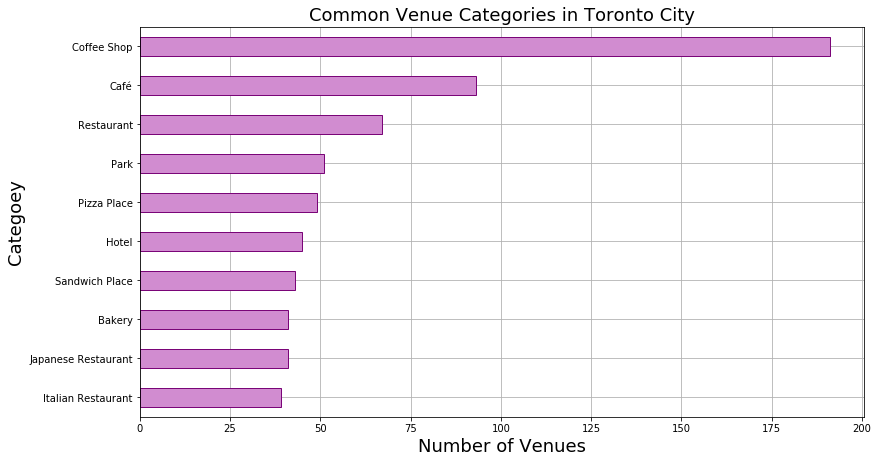

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
toronto_top_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
ax = toronto_top_vc.head(10).plot(kind='barh', grid=True, color = "#d18cd0", edgecolor='#7a0578');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Toronto City', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('toronto_most_common_venue.png', dpi=300)

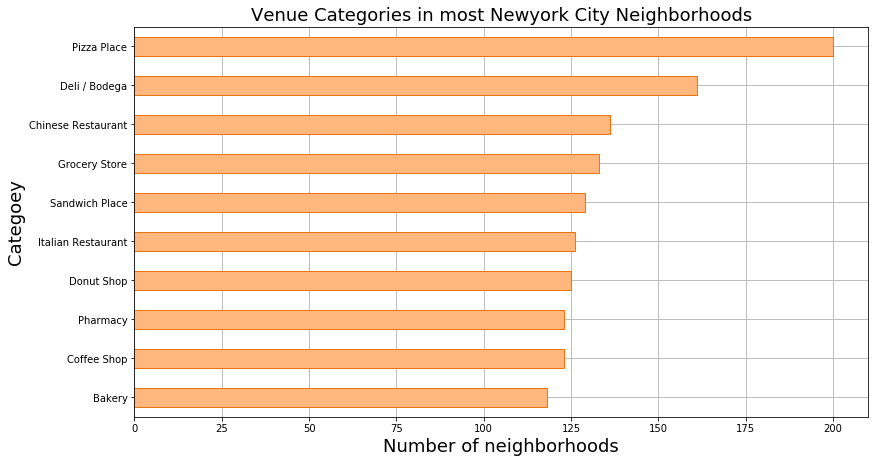

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
newyork_groupby = newyork_onehot.groupby('Neighborhood_').max().reset_index()
newyork_sorted = newyork_groupby.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
ax = newyork_sorted.head(10).plot(kind='barh', grid=True, color = "#ffb77d", edgecolor='#eb7413');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most Newyork City Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('newyork_venue_in_more_neighborhood.png', dpi=300)

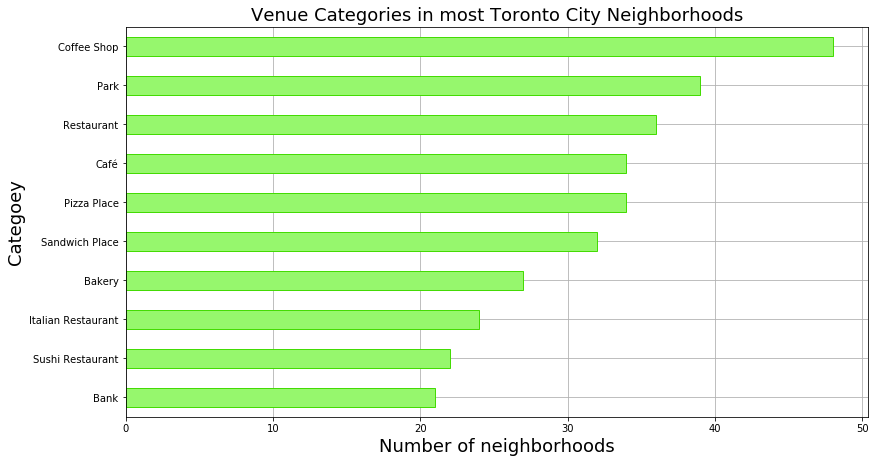

In [71]:
fig, ax = plt.subplots(figsize=(12,6))
toronto_groupby = toronto_onehot.groupby('Neighborhood_').max().reset_index()
toronto_sorted = toronto_groupby.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
ax = toronto_sorted.head(10).plot(kind='barh', grid=True, color = "#96f76d", edgecolor='#44db04');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Venue Categories in most Toronto City Neighborhoods', fontsize=18)
plt.xlabel("Number of neighborhoods", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('toronto_venue_in_more_neighborhood.png', dpi=300)

In [ ]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12,6))
toronto_top_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
ax = toronto_top_vc.head(10).plot(kind='barh', grid=True, color = "#d18cd0", edgecolor='#7a0578');
ax.invert_yaxis()
ax.set_axisbelow(True)
plt.tight_layout()
plt.title('Common Venue Categories in Toronto City', fontsize=18)
plt.xlabel("Number of Venues", fontsize=18)
plt.ylabel("Categoey", fontsize=18)
fig.savefig('toronto_most_common_venue.png', dpi=300)

In [72]:
newyork_bottom_venue_count = newyork_venues['Venue Category'].value_counts(normalize=False)
newyork_bottom_venue_count = newyork_bottom_venue_count.tail(10).to_frame('Count')
newyork_bottom_venue_count.index.names = ['Venue Category']
newyork_bottom_venue_count

,Count
Venue Category,
Sri Lankan Restaurant,1
Varenyky restaurant,1
Adult Boutique,1
Theme Restaurant,1
Baby Store,1
Waste Facility,1
Airport Terminal,1
Comic Shop,1
Hockey Field,1


In [73]:
toronto_bottom_venue_count = toronto_venues['Venue Category'].value_counts(normalize=False)
toronto_bottom_venue_count = toronto_bottom_venue_count.tail(10).to_frame('Count')
toronto_bottom_venue_count.index.names = ['Venue Category']
toronto_bottom_venue_count

,Count
Venue Category,
Doner Restaurant,1
College Auditorium,1
Hospital,1
College Arts Building,1
Motel,1
Airport Gate,1
Tennis Court,1
Health & Beauty Service,1
Organic Grocery,1


In [74]:
columns_newyork_only = set(newyork_grouped.columns).difference(set(toronto_grouped.columns))
columns_toronto_only = set(toronto_grouped.columns).difference(set(newyork_grouped.columns))

In [75]:
newyork_grouped_ = newyork_grouped.copy()
newyork_grouped_['Neighborhood_'] = newyork_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
toronto_grouped_ = toronto_grouped.copy()
toronto_grouped_['Neighborhood_'] = toronto_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in columns_toronto_only:
    newyork_grouped_[c] = 0
for c in columns_newyork_only:
    toronto_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(newyork_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
newyork_grouped_ = newyork_grouped_[all_clmns_sorted]
toronto_grouped_ = toronto_grouped_[all_clmns_sorted]
    
newyork_toronto_grouped = pd.concat([newyork_grouped_, toronto_grouped_]).reset_index(drop=True)

In [76]:
# obtaining the most popular categories for each neighborhood
newyork_toronto_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
newyork_toronto_neighborhoods_categories_sorted['Neighborhood_'] = newyork_toronto_grouped['Neighborhood_']

for ind in np.arange(newyork_toronto_grouped.shape[0]):
    newyork_toronto_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        newyork_toronto_grouped.iloc[ind, :], num_top_venues)

newyork_toronto_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton_NYC,Pizza Place,Spa,Supermarket,Chinese Restaurant,Deli / Bodega,Breakfast Spot,Grocery Store,Donut Shop,Electronics Store,Martial Arts School
1,Annadale_NYC,Pizza Place,American Restaurant,Diner,Restaurant,Train Station,Park,Food,Dance Studio,Deli / Bodega,Factory
2,Arden Heights_NYC,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Bus Stop,Yoga Studio,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
3,Arlington_NYC,Deli / Bodega,Bus Stop,Boat or Ferry,Coffee Shop,Home Service,Grocery Store,Eye Doctor,Farm,Falafel Restaurant,Factory
4,Arrochar_NYC,Bus Stop,Italian Restaurant,Deli / Bodega,Cosmetics Shop,Pizza Place,Supermarket,Middle Eastern Restaurant,Mediterranean Restaurant,Beach,Outdoors & Recreation


In [80]:
# the number of clusters
kclusters = 5
newyork_toronto_grouped_clustering = newyork_toronto_grouped.drop('Neighborhood_', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [81]:
# add clustering labels
newyork_toronto_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_toronto_merged = newyork_toronto_neighborhoods_categories_sorted.set_index('Neighborhood_')
newyork_toronto_merged.iloc[300:310] # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

In [82]:
Cluster_1 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 0, :]
Cluster_1

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Allerton_NYC,0,Pizza Place,Spa,Supermarket,Chinese Restaurant,Deli / Bodega,Breakfast Spot,Grocery Store,Donut Shop,Electronics Store,Martial Arts School
Annadale_NYC,0,Pizza Place,American Restaurant,Diner,Restaurant,Train Station,Park,Food,Dance Studio,Deli / Bodega,Factory
Arden Heights_NYC,0,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Bus Stop,Yoga Studio,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
Bedford Park_NYC,0,Diner,Mexican Restaurant,Pizza Place,Chinese Restaurant,Spanish Restaurant,Supermarket,Sandwich Place,Pharmacy,Deli / Bodega,Convenience Store
Borough Park_NYC,0,Bank,Pizza Place,Café,Pharmacy,Fast Food Restaurant,American Restaurant,Metro Station,Chinese Restaurant,Restaurant,Coffee Shop
Broad Channel_NYC,0,Pizza Place,Sporting Goods Shop,Deli / Bodega,Other Nightlife,Dive Bar,Yoga Studio,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
Bulls Head_NYC,0,Pizza Place,Chinese Restaurant,Bus Stop,Ice Cream Shop,Pharmacy,Sandwich Place,Deli / Bodega,Grocery Store,Thai Restaurant,Coffee Shop
Castle Hill_NYC,0,Park,Bus Station,Market,Pharmacy,Bank,Diner,Pizza Place,Supermarket,Flower Shop,Factory
Castleton Corners_NYC,0,Pizza Place,Bank,Go Kart Track,Sandwich Place,Bar,Burger Joint,Japanese Restaurant,Ice Cream Shop,Bagel Shop,Grocery Store


In [83]:
Cluster_2 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 1, :]
Cluster_2

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Butler Manor_NYC,1,Baseball Field,Pool,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
Mill Island_NYC,1,Pool,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
"The Kingsway, Montgomery Road, Old Mill North_Toronto",1,Pool,River,Yoga Studio,Farm,Electronics Store,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service


In [84]:
Cluster_3 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 2, :]
Cluster_3

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
"Humberlea, Emery_Toronto",2,Baseball Field,Yoga Studio,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East_Toronto",2,Construction & Landscaping,Baseball Field,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
"Rouge Hill, Port Union, Highland Creek_Toronto",2,Bar,Construction & Landscaping,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit


In [85]:
Cluster_4 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 3, :]
Cluster_4

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Clason Point_NYC,3,Park,South American Restaurant,Boat or Ferry,Bus Stop,Pool,Grocery Store,Convenience Store,Event Service,Ethiopian Restaurant,Farm
Somerville_NYC,3,Park,Yoga Studio,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
Todt Hill_NYC,3,Park,Yoga Studio,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
Caledonia-Fairbanks_Toronto,3,Park,Women's Store,Pool,Yoga Studio,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
"East Toronto, Broadview North (Old East York)_Toronto",3,Intersection,Convenience Store,Park,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
Parkwoods_Toronto,3,Park,Food & Drink Shop,Yoga Studio,Farmers Market,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
Rosedale_Toronto,3,Park,Trail,Playground,Yoga Studio,Farm,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
Weston_Toronto,3,Park,Yoga Studio,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
York Mills West_Toronto,3,Convenience Store,Park,Yoga Studio,Farmers Market,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space


In [86]:
Cluster_5 = newyork_toronto_merged.loc[newyork_toronto_merged['Cluster Labels'] == 4, :]
Cluster_5

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighborhood_,,,,,,,,,,,
Arlington_NYC,4,Deli / Bodega,Bus Stop,Boat or Ferry,Coffee Shop,Home Service,Grocery Store,Eye Doctor,Farm,Falafel Restaurant,Factory
Arrochar_NYC,4,Bus Stop,Italian Restaurant,Deli / Bodega,Cosmetics Shop,Pizza Place,Supermarket,Middle Eastern Restaurant,Mediterranean Restaurant,Beach,Outdoors & Recreation
Arverne_NYC,4,Surf Spot,Sandwich Place,Metro Station,Restaurant,Pizza Place,Beach,Donut Shop,Coffee Shop,Café,Bus Stop
Astoria_NYC,4,Middle Eastern Restaurant,Bar,Hookah Bar,Seafood Restaurant,Pizza Place,Bakery,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Café
Astoria Heights_NYC,4,Bakery,Supermarket,Laundromat,Bus Station,Pizza Place,Hostel,Playground,Plaza,Chinese Restaurant,Bowling Alley
Auburndale_NYC,4,Italian Restaurant,Korean Restaurant,Fast Food Restaurant,Toy / Game Store,Pharmacy,Sushi Restaurant,Train,Athletics & Sports,Supermarket,Discount Store
Bath Beach_NYC,4,Chinese Restaurant,Pharmacy,Bubble Tea Shop,Donut Shop,Italian Restaurant,Fast Food Restaurant,Cantonese Restaurant,Gas Station,Dessert Shop,Pizza Place
Battery Park City_NYC,4,Park,Hotel,Coffee Shop,Gym,Memorial Site,Plaza,Shopping Mall,Pizza Place,Burger Joint,Food Court
Bay Ridge_NYC,4,Italian Restaurant,Spa,Pizza Place,Bar,American Restaurant,Greek Restaurant,Thai Restaurant,Bagel Shop,Grocery Store,Sushi Restaurant


In [87]:
clust_cats = []
clusters = [Cluster_1, Cluster_2, Cluster_3, Cluster_4, Cluster_5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(newyork_venues[newyork_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(toronto_venues[toronto_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [88]:
! pip install tabulate
from tabulate import tabulate
for i in range(kclusters):
    df = pd.DataFrame(data=clust_cats[i], columns=["% of venues"])
#     print(type(clust_cats[i]))
#     df = pd.DataFrame(data=clust_cats[i])
#     print(df.head(7))
    print("\n\n\t Cluster {}".format(i+1))
    print(tabulate(df.head(7), headers = 'keys', tablefmt = 'fancy_grid'))


You are using pip version 9.0.1, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


	 Cluster 1
╒════════════════════╤═══════════════╕
│                    │   % of venues │
╞════════════════════╪═══════════════╡
│ Pizza Place        │      13.0587  │
├────────────────────┼───────────────┤
│ Pharmacy           │       5.34619 │
├────────────────────┼───────────────┤
│ Deli / Bodega      │       5.08326 │
├────────────────────┼───────────────┤
│ Grocery Store      │       4.73269 │
├────────────────────┼───────────────┤
│ Chinese Restaurant │       4.38212 │
├────────────────────┼───────────────┤
│ Bank               │       3.5057  │
├────────────────────┼───────────────┤
│ Sandwich Place     │       2.62927 │
╘════════════════════╧═══════════════╛


	 Cluster 2
╒════════════════╤═══════════════╕
│                │   % of venues │
╞════════════════╪═══════════════╡
│ Pool           │       57.1429 │
├────────────────┼──────

In [89]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

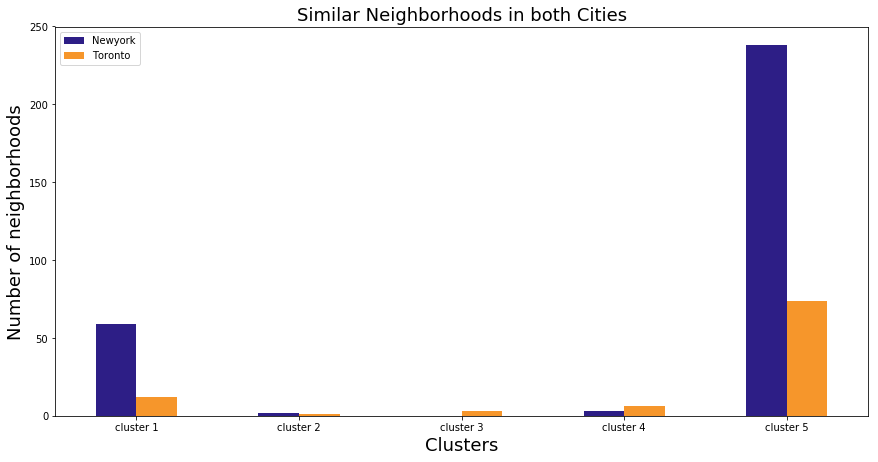

In [90]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'Newyork': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=(12,6))
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)

# plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
plt.tight_layout()
plt.title('Similar Neighborhoods in both Cities', fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.ylabel("Number of neighborhoods", fontsize=18)
fig.savefig('similar_neighborhoods.png', dpi=300)

## Result and Discuission

The differences between the clusters can be seen from the figure; each cluster has a different distribution of common venue categories. The first cluster consist of venues related with food and restaurants such as Pizza Place, Deli/Bodega and Chinese Restaurant. The second cluster consists of River, Pool, Baseball Field which are mostly the outdoor sports venues. The third cluster consists of landscaping, bar and baseball field again which may be a good area for tourism. In the fourth cluster, the park has 51.7% as the most common venues and there are also some transportation such as bus stop, boat or Ferry and Intersection. In the fifth cluster, the food and drink venues are the major venues again. So we can find the cluster 1 is quite similar to the cluster 5.

## Conclusion

In this project, the areas of New York City and Toronto were clustered into various groups dependent on the classifications (kinds) of the venues in these areas. The outcomes demonstrated that there are venue categories that are more common in 1st and 5th clusters; Also these most common venue categories contrast from one cluster to the next. So using this information one can make decisions and be able to find similar neighbourhoods in the new City. It will also help business starters to find the best types of business to start and they may also can use the development of the other clusters as a reference. In the future if a more profound investigation is performed considering more viewpoints, it may bring about finding various styles in each cluster dependent on the most common categories in the cluster.